In [1]:
import importlib
import pandas as pd
import numpy as np
import math
import itertools
from tqdm import tqdm 
import xarray as xr
from scipy.stats import genextreme
import re
import datetime
import matplotlib.pyplot as plt # Assumed installed for example plot
from scipy.spatial.distance import cdist
from GEV import * 
from utils import *

Data Generation functions : Independant GRID

In [2]:
def create_independent_gev_grid(loc, scale, shape,
                                num_x=5, num_y=5, num_t=5):
    """
    Generates an xarray.Dataset with independent GEV samples at each point.

    Each value in the grid (x, y, t) is drawn independently from the same
    GEV(loc, scale, shape) distribution.

    Args:
        loc (float): The location parameter (mu) of the GEV distribution.
        scale (float): The scale parameter (sigma > 0) of the GEV distribution.
        shape (float): The shape parameter (xi) of the GEV distribution.
                       Note: Internally uses c = -shape for scipy.stats.genextreme.
                       shape < 0 (c > 0) => Weibull type (bounded above)
                       shape = 0 (c = 0) => Gumbel type
                       shape > 0 (c < 0) => Fréchet type (heavy tail)
        num_x (int): Number of points along the x dimension. Default is 5.
        num_y (int): Number of points along the y dimension. Default is 5.
        num_t (int): Number of points along the t dimension. Default is 5.

    Returns:
        xarray.Dataset: An xarray Dataset with dimensions ('x', 'y', 't')
                        and a single data variable 'extreme_value' containing
                        independent GEV samples.

    Raises:
        ValueError: If the scale parameter is not positive.
    """
    # --- Input Validation ---
    if scale <= 0:
        raise ValueError("Scale parameter (sigma) must be positive.")

    # --- Define Coordinates ---
    x_coords = np.arange(num_x)
    y_coords = np.arange(num_y)
    t_coords = np.arange(num_t)

    # --- Generate GEV Data ---
    total_values = num_x * num_y * num_t
    # Generate independent samples using the specified parameters
    # Note: Using c = -shape consistent with user input convention
    gev_data_flat = genextreme.rvs(c=-shape, loc=loc, scale=scale, size=total_values)
    gev_data_3d = gev_data_flat.reshape(num_x, num_y, num_t)

    # --- Create xarray DataArray ---
    data_variable = xr.DataArray(
        data=gev_data_3d,
        coords={'lon': x_coords, 'lat': y_coords, 'time': t_coords},
        dims=['lon', 'lat', 'time'],
        name='extreme_value',
        attrs={
            'description': 'Independent synthetic data generated from a GEV distribution.',
            'units': 'unitless',
            'location': loc,
            'scale': scale,
            'shape': shape, # Store the input shape parameter (xi)
        }
    )
    # --- Create xarray Dataset ---
    dataset = xr.Dataset({'extreme_value': data_variable})
    dataset.attrs['creation_timestamp'] = datetime.datetime.now().isoformat()
    dataset.attrs['source'] = 'Generated by create_independent_gev_grid'
    dataset.attrs['grid_type'] = 'dimensionless integer coordinates'
    dataset.attrs['dependencies'] = 'Identically distributed, independent samples'

    return dataset

Data Generation functions : Dependant GRID

In [3]:
TrendFunction = Callable[[np.ndarray, np.ndarray, np.ndarray], np.ndarray]
def generate_simple_trend_st(
    seed: int = 2,
    coeff_range: Tuple[float, float] = (0.0, 5.0), # Spatial coeff range (x or y)
    intercept_range: Tuple[float, float] = (10.0, 20.0), # Intercept range
    t_coeff_range: Tuple[float, float] = (0.0, 2.0), # Time coeff range (applied to t=[0,1])
    variable_choice: List[str] = ['x', 'y'] # Spatial variable choice
) -> Tuple[TrendFunction,Tuple[float,float,float]]:
    """
    Generates a linear trend lambda: f(x,y,t) = intercept + coeff*spatial_var + t_coeff*t.

    Randomly selects a spatial variable ('x' or 'y'), coefficients for the
    spatial and temporal components from their respective ranges, and an
    intercept from its range. The time coefficient `t_coeff` applies to a time
    coordinate `t` normalized between 0 and 1.

    Args:
        seed (int): Seed for the random number generator.
        coeff_range (Tuple[float, float]): Min/max range for the spatial coefficient (applied to x or y).
        intercept_range (Tuple[float, float]): Min/max range for the intercept.
        t_coeff_range (Tuple[float, float]): Min/max range for the time coefficient (applied to normalized t=[0,1]).
        variable_choice (List[str]): List of spatial variables ('x' or 'y') to choose from.
                                     Defaults to ['x', 'y'].

    Returns:
        TrendFunction: A lambda function matching the required signature
                       (lambda x_grid, y_grid, t_grid: ...) that calculates
                       the generated linear trend.

    Raises:
        ValueError: If variable_choice is empty or contains invalid variables (not 'x' or 'y').
    """
    rng = np.random.default_rng(seed)

    if not variable_choice:
        raise ValueError("variable_choice list cannot be empty.")

    # 1. Choose spatial variable
    variable = rng.choice(variable_choice)
    if variable not in ['x', 'y']:
         raise ValueError(f"Invalid spatial variable '{variable}' chosen. Must be 'x' or 'y'.")

    # 2. Sample coefficients and intercept
    coeff = rng.uniform(coeff_range[0], coeff_range[1])
    t_coeff = rng.uniform(t_coeff_range[0], t_coeff_range[1])
    intercept = rng.uniform(intercept_range[0], intercept_range[1])

    # 3. Construct a clear string representation of the function
    func_str = f"f(x,y,t) = {intercept:+.3f}"
    if abs(coeff) > 1e-9: # Avoid printing "+ 0.000 * x"
        func_str += f" {coeff:+.3f}*{variable}"
    if abs(t_coeff) > 1e-9: # Avoid printing "+ 0.000 * t"
        # Indicate that t is normalized in the printed string for clarity
        func_str += f" {t_coeff:+.3f}*t_norm"

    #print(f"Generated Trend Lambda: {func_str}") # Note: t_norm used in print only

    # 4. Return the corresponding lambda function
    return (lambda x_grid, y_grid, t_grid, i=intercept, c=coeff, tc=t_coeff: i + c * x_grid + tc * t_grid, (intercept,coeff,t_coeff))
    #if variable == 'x':
        # Capture values in the lambda closure
        #return (lambda x_grid, y_grid, t_grid, i=intercept, c=coeff, tc=t_coeff: i + c * x_grid + tc * t_grid, (intercept,coeff,t_coeff))
    #: # variable == 'y'
        # Capture values in the lambda closure
        #return (lambda x_grid, y_grid, t_grid, i=intercept, c=coeff, tc=t_coeff: i + c * y_grid + tc * t_grid, (intercept,coeff,t_coeff))


# --- Main GEV Data Generation Function ---
def create_gev_nonstationary(
    loc: float = 0.0,
    scale: float = 1.0,
    shape: float = 0.0,
    trend_funcs: Optional[Dict[str, Optional[TrendFunction]]] = None,
    num_x: int = 50,
    num_y: int = 50,
    num_t: int = 5,
    seed: int = 0
) -> xr.Dataset:
    """
    Generates GEV data with potentially non-stationary location, scale, and shape parameters
    varying as functions of normalized spatial coordinates (x, y) and normalized time (t).

    This version accepts user-defined functions (including lambdas) for trends.

    Coordinates:
        - x: Runs from 0 to 1 along the 'lon' dimension.
        - y: Runs from 0 to 1 along the 'lat' dimension.
        - t: Runs from 0 to 1 along the 'time' dimension. (Normalized)

    Each parameter (loc, scale, shape) is calculated as:
    param(x, y, t) = base_param + trend_function(x, y, t)
    The `trend_function` is provided directly as a callable via the `trend_funcs` dictionary.
    If the corresponding key ('loc', 'scale', 'shape') is missing or its value is None
    in `trend_funcs`, the parameter is constant (base_param).

    **Trend Function Signature:**
    Any function provided must accept three arguments:
        1. x_grid (np.ndarray): Meshgrid of x coordinates [0,1] (shape: num_x, num_y, num_t).
        2. y_grid (np.ndarray): Meshgrid of y coordinates [0,1] (shape: num_x, num_y, num_t).
        3. t_grid (np.ndarray): Meshgrid of **normalized** t coordinates [0,1] (shape: num_x, num_y, num_t).
    It must return a numpy array of the same shape (num_x, num_y, num_t) representing
    the trend component to be added to the base parameter value.

    Args:
        loc (float): Base value for the location parameter (mu). Default is 0.0.
        scale (float): Base value for the scale parameter (sigma). Must be > 0 if no
                       scale trend function is provided. Default is 1.0.
        shape (float): Base value for the shape parameter (xi). Default is 0.0.
        trend_funcs (Dict[str, Optional[TrendFunction]], optional): Dictionary mapping
            parameter names ('loc', 'scale', 'shape') to optional callable functions
            that define the trend. Defaults to None (no trends).
            Example:
            {
                # Trend increases by 0.5 over the full normalized time period
                'loc': lambda x, y, t: 0.5 * t + 0.1 * x,
                'scale': my_scale_func # where my_scale_func is defined elsewhere
            }
        num_x (int): Number of points along the x dimension ('lon'). Default is 50.
        num_y (int): Number of points along the y dimension ('lat'). Default is 50.
        num_t (int): Number of points along the t dimension ('time'). Default is 5.
        seed (int): Seed for the random number generator used for GEV sampling. Default is 0.

    Returns:
        xarray.Dataset: An xarray Dataset containing GEV samples ('extreme_value')
                        and the calculated parameters ('location', 'scale', 'shape')
                        with potentially varying parameters. Base values and representations
                        of the trend functions used are stored as attributes.

    Raises:
        ValueError: If base scale <= 0 (and no trend func), if calculated scale <= 0,
                    or if a provided trend function returns an array of incorrect shape.
        TypeError: If an object provided in `trend_funcs` is not callable or does not
                   match the required signature.
        Exception: Any exception raised by the user-provided trend functions.
    ```
    """
    # Initialize trend_funcs if None
    if trend_funcs is None:
        trend_funcs = {}

    # Extract trend functions for validation and attribute storage
    loc_trend_func = trend_funcs.get('loc', None)
    scale_trend_func = trend_funcs.get('scale', None)
    shape_trend_func = trend_funcs.get('shape', None)

    # --- Basic Input Validation ---
    if scale_trend_func is None and scale <= 0:
        raise ValueError("Base scale parameter (sigma) must be positive if scale trend function is not provided.")

    # --- Define Coordinates (Normalized x, y, t) ---
    x_coords = np.linspace(0, 1, num_x)
    y_coords = np.linspace(0, 1, num_y)
    # *** MODIFIED: Use linspace for t to normalize between 0 and 1 ***
    t_coords = np.linspace(0, 1, num_t)
    expected_shape = (num_x, num_y, num_t)

    # --- Create meshgrids for x, y, t ---
    # Use 'ij' indexing so shape matches (num_x, num_y, num_t)
    # t_grid will now contain values between 0 and 1.
    x_grid, y_grid, t_grid = np.meshgrid(x_coords, y_coords, t_coords, indexing='ij')

    # --- Helper function to calculate a single parameter using a provided function ---
    def _calculate_parameter(param_name: str, base_value: float,
                             trend_func: Optional[TrendFunction],
                             x: np.ndarray, y: np.ndarray, t: np.ndarray) -> np.ndarray:
        """Calculates the parameter array by calling the trend function if provided."""

        if trend_func is None:
            # No trend, use constant base value
            return np.full(expected_shape, base_value, dtype=float)

        if not callable(trend_func):
            raise TypeError(f"Object provided for '{param_name}' trend is not callable (not a function or lambda).")

        try:
            # Call the user-provided function (passing normalized t_grid)
            trend_component = trend_func(x, y, t)

            # Validate the output shape
            if not isinstance(trend_component, np.ndarray) or trend_component.shape != expected_shape:
                 # Try broadcasting if scalar output is given
                 if np.isscalar(trend_component):
                     trend_component = np.full(expected_shape, trend_component, dtype=float)
                 else:
                    raise ValueError(f"Trend function for '{param_name}' returned an array with "
                                     f"shape {np.shape(trend_component)}, but expected {expected_shape}.")

        except TypeError as e:
            # Catch errors likely related to incorrect function signature
            raise TypeError(f"Error calling trend function for '{param_name}'. "
                            f"Ensure it accepts 3 arguments (x_grid, y_grid, t_grid). Original error: {e}") from e
        except Exception as e:
            # Re-raise any other exceptions from the user's function
            raise RuntimeError(f"Error executing trend function for '{param_name}'. Original error: {e}") from e

        # Add trend to the base value
        param_array = base_value + trend_component.astype(float) # Ensure float type

        return param_array

    # --- Calculate Spatially and Temporally Varying Parameters ---
    try:
        loc_xyt = _calculate_parameter('loc', loc, loc_trend_func, x_grid, y_grid, t_grid)
        scale_xyt = _calculate_parameter('scale', scale, scale_trend_func, x_grid, y_grid, t_grid)
        shape_xyt = _calculate_parameter('shape', shape, shape_trend_func, x_grid, y_grid, t_grid)
    except (ValueError, TypeError, RuntimeError) as e:
        # Re-raise calculation errors for clarity
        raise e
    except Exception as e:
        # Catch unexpected errors during calculation
        raise RuntimeError(f"An unexpected error occurred during parameter calculation: {e}") from e


    # --- Validate Calculated Scale Parameter ---
    if np.any(scale_xyt <= 0):
        min_scale = np.min(scale_xyt)
        raise ValueError(f"Calculated scale parameter must be positive everywhere, but found "
                         f"minimum value {min_scale:.4f}. Check base 'scale' ({scale}) and "
                         f"the 'scale' trend function: {scale_trend_func!r}.") # Use repr for function

    # --- Generate GEV Data ---
    # Use the calculated parameter arrays. Note: scipy.stats.genextreme uses c = -shape.
    rng = np.random.default_rng(seed)
    gev_data_3d = genextreme.rvs(c=-shape_xyt, loc=loc_xyt, scale=scale_xyt,
                                 size=expected_shape, random_state=rng)

    # --- Create xarray DataArrays for parameters and data ---
    # Use the normalized t_coords for the time dimension
    coords_dict = {'lon': x_coords, 'lat': y_coords, 'time': t_coords}
    dims_list = ['lon', 'lat', 'time']

    # Helper to get a string representation of the function for attributes
    def func_repr(func):
        if func is None:
            return 'None'
        try:
            # Use repr for better info, especially for named functions
            return repr(func)
        except Exception:
            return str(func) # Fallback

    data_var = xr.DataArray(
        data=gev_data_3d,
        coords=coords_dict,
        dims=dims_list,
        name='extreme_value',
        attrs={
            'description': 'Synthetic GEV samples.',
            'units': 'unitless', # Adjust if applicable
            'gev_rng_seed': seed,
        }
    )
    loc_var = xr.DataArray(
        data=loc_xyt, coords=coords_dict, dims=dims_list, name='location',
        attrs={'description': 'GEV location parameter (mu)', 'base_value': loc, 'trend_function': func_repr(loc_trend_func)}
    )
    scale_var = xr.DataArray(
        data=scale_xyt, coords=coords_dict, dims=dims_list, name='scale',
         attrs={'description': 'GEV scale parameter (sigma)', 'base_value': scale, 'trend_function': func_repr(scale_trend_func)}
    )
    shape_var = xr.DataArray(
        data=shape_xyt, coords=coords_dict, dims=dims_list, name='shape',
        attrs={'description': 'GEV shape parameter (xi)', 'base_value': shape, 'trend_function': func_repr(shape_trend_func)}
    )

    # --- Create xarray Dataset ---
    dataset = xr.Dataset({
        'extreme_value': data_var,
        'location': loc_var,
        'scale': scale_var,
        'shape': shape_var
        })

    dataset.attrs['creation_timestamp'] = datetime.datetime.now(datetime.timezone.utc).isoformat()
    dataset.attrs['source'] = 'Generated by create_gev_nonstationary_lambda'
    # *** MODIFIED: Update grid_type attribute ***
    dataset.attrs['grid_type'] = 'normalized spatial and temporal coordinates (0-1)'
    dataset.attrs['dependencies'] = 'Spatio-temporal dependence via user-provided functions for loc, scale, and shape.'
    # Store the input trend function dictionary representation for reference
    dataset.attrs['input_trend_funcs'] = str({k: func_repr(v) for k, v in trend_funcs.items()})


    return dataset

print("\n--- Example 2: Lambda Trends (Normalized Time) ---")
trends = {
    'loc': lambda x, y, t: 0.1 * t,          # loc = 10 + 0.5*t (t is 0->1)
    'scale': lambda x, y, t: 3 + 12*x      # scale = 2 - 0.1 = 1.9
}
ds_trends = create_gev_nonstationary(
    loc=10, scale=2, shape=0.1, trend_funcs=trends, num_x=3, num_y=3, num_t=100, seed=42
)
print(ds_trends)


--- Example 2: Lambda Trends (Normalized Time) ---
<xarray.Dataset> Size: 30kB
Dimensions:        (lon: 3, lat: 3, time: 100)
Coordinates:
  * lon            (lon) float64 24B 0.0 0.5 1.0
  * lat            (lat) float64 24B 0.0 0.5 1.0
  * time           (time) float64 800B 0.0 0.0101 0.0202 ... 0.9798 0.9899 1.0
Data variables:
    extreme_value  (lon, lat, time) float64 7kB 17.29 10.98 ... 1.473 17.58
    location       (lon, lat, time) float64 7kB 10.0 10.0 10.0 ... 10.1 10.1
    scale          (lon, lat, time) float64 7kB 5.0 5.0 5.0 ... 17.0 17.0 17.0
    shape          (lon, lat, time) float64 7kB 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1
Attributes:
    creation_timestamp:  2025-04-18T14:59:11.325872+00:00
    source:              Generated by create_gev_nonstationary_lambda
    grid_type:           normalized spatial and temporal coordinates (0-1)
    dependencies:        Spatio-temporal dependence via user-provided functio...
    input_trend_funcs:   {'loc': '<function <lambda> at 0x0

Data visualization functions

In [4]:
def plot_time(
    data: Union[xr.Dataset, xr.DataArray],
    lon_index: int = 0,
    lat_index: int = 0,
    var_name: Optional[str] = 'extreme_value',
    lon_dim: str = 'lon', # Added dimension name args
    lat_dim: str = 'lat',
    time_dim: str = 'time'
) -> None:
    """
    Plots the time series for a specific spatial point in the xarray data.

    Args:
        data: The dataset or data array containing the variable to plot.
              Must have dimensions corresponding to lon_dim, lat_dim, time_dim.
        lon_index: The integer index for the longitude dimension.
        lat_index: The integer index for the latitude dimension.
        var_name: The name of the variable to plot if 'data' is a Dataset.
                  If 'data' is a DataArray, this is used for labeling unless None.
                  Defaults to 'extreme_value'.
        lon_dim: Name of the longitude dimension (default: 'lon').
        lat_dim: Name of the latitude dimension (default: 'lat').
        time_dim: Name of the time dimension (default: 'time').
    """
    da = None
    actual_var_name = None

    # --- Extract DataArray ---
    if isinstance(data, xr.Dataset):
        if var_name is None:
             print(f"Error: var_name must be specified when providing a Dataset.")
             return
        if var_name not in data:
            print(f"Error: Dataset does not contain variable '{var_name}'. "
                  f"Available variables: {list(data.data_vars.keys())}")
            return
        da = data[var_name]
        actual_var_name = var_name
    elif isinstance(data, xr.DataArray):
        da = data
        actual_var_name = data.name or var_name or "Data" # Use DA name, fallback to arg or default
    else:
        print("Error: Input 'data' must be an xarray Dataset or DataArray.")
        return

    # --- Validate Dimensions ---
    required_dims = {lon_dim, lat_dim, time_dim}
    if not required_dims.issubset(da.dims):
         print(f"Error: DataArray '{actual_var_name}' is missing one or more required dimensions: "
               f"{required_dims}. Found dimensions: {da.dims}")
         return

    try:
        # --- Select Data Point ---
        # Select the data point using integer indices based on provided dim names
        selection_indices = {lon_dim: lon_index, lat_dim: lat_index}
        selected_point_data = da.isel(**selection_indices)

        # --- Create Plot ---
        plt.figure(figsize=(10, 5))
        selected_point_data.plot.line(marker='.', linestyle='-') # Use xarray's plotting

        # --- Customize Plot ---
        # Attempt to get coordinate values for title, fallback if coords missing
        try:
             lon_val_str = f"{selected_point_data[lon_dim].item():.2f}"
        except:
             lon_val_str = f"index {lon_index}" # Fallback if coord missing/not scalar

        try:
             lat_val_str = f"{selected_point_data[lat_dim].item():.2f}"
        except:
             lat_val_str = f"index {lat_index}" # Fallback

        plt.title(f"Time Series for '{actual_var_name}'\nat {lon_dim}={lon_val_str}, {lat_dim}={lat_val_str}")
        plt.xlabel(f"Time ({time_dim})")
        plt.ylabel(actual_var_name)
        plt.grid(True, alpha=0.5)
        plt.tight_layout()
        plt.show()

    except IndexError:
        print(f"Error: Indices {lon_dim}={lon_index}, {lat_dim}={lat_index} are out of bounds "
              f"for data with shape {da.shape}. Check dimensions: {da.dims}.")
    except Exception as e:
        print(f"An error occurred during time series plotting: {e}")


def plot_map(
    data: Union[xr.Dataset, xr.DataArray],
    t_index: int = 0,
    var_name: Optional[str] = 'extreme_value',
    lon_dim: str = 'lon', # Added dimension name args
    lat_dim: str = 'lat',
    time_dim: str = 'time'
) -> None:
    """
    Plots a 2D spatial map (image) of the data at a specific time index 't'.

    Args:
        data: The dataset or data array containing the variable to plot.
              Must have dimensions corresponding to lon_dim, lat_dim, time_dim.
        t_index: The integer index for the time dimension.
        var_name: The name of the variable to plot if 'data' is a Dataset.
                  If 'data' is a DataArray, this is used for labeling unless None.
                  Defaults to 'extreme_value'.
        lon_dim: Name of the longitude dimension (default: 'lon').
        lat_dim: Name of the latitude dimension (default: 'lat').
        time_dim: Name of the time dimension (default: 'time').
    """
    da = None
    actual_var_name = None

    # --- Extract DataArray ---
    if isinstance(data, xr.Dataset):
        if var_name is None:
             print(f"Error: var_name must be specified when providing a Dataset.")
             return
        if var_name not in data:
            print(f"Error: Dataset does not contain variable '{var_name}'. "
                  f"Available variables: {list(data.data_vars.keys())}")
            return
        da = data[var_name]
        actual_var_name = var_name
    elif isinstance(data, xr.DataArray):
        da = data
        actual_var_name = data.name or var_name or "Data"
    else:
        print("Error: Input 'data' must be an xarray Dataset or DataArray.")
        return

    # --- Validate Dimensions ---
    required_dims = {lon_dim, lat_dim, time_dim}
    if not required_dims.issubset(da.dims):
         print(f"Error: DataArray '{actual_var_name}' is missing one or more required dimensions: "
               f"{required_dims}. Found dimensions: {da.dims}")
         return

    try:
        # --- Select Time Slice ---
        selection_indices = {time_dim: t_index}
        selected_time_slice = da.isel(**selection_indices)

        # --- Create Plot ---
        plt.figure(figsize=(8, 7)) # Adjusted size slightly
        # Ensure plot uses correct x,y dimensions based on args
        selected_time_slice.plot.imshow(
            x=lon_dim, y=lat_dim, cmap='viridis', robust=True # robust handles outliers in color scale
        )

        # --- Customize Plot ---
        # Attempt to get time coordinate value for title
        try:
             time_val_str = f"{selected_time_slice[time_dim].item()}"
             # Try formatting nicely if it's datetime-like
             if np.issubdtype(selected_time_slice[time_dim].dtype, np.datetime64):
                  # Convert numpy datetime64 to something more readable if possible
                  try:
                       time_val_str = str(selected_time_slice[time_dim].dt.round('s').item()) # Round to nearest second
                  except: pass # Keep original if conversion fails
             elif np.issubdtype(selected_time_slice[time_dim].dtype, np.timedelta64):
                  try:
                       time_val_str = str(selected_time_slice[time_dim].dt.round('s').item())
                  except: pass
        except:
             time_val_str = f"index {t_index}" # Fallback

        plt.title(f"Spatial Map for '{actual_var_name}'\nat {time_dim} = {time_val_str}")
        # Labels are usually handled well by xarray based on coordinates
        # plt.xlabel(f"{lon_dim}") # Usually set automatically
        # plt.ylabel(f"{lat_dim}") # Usually set automatically
        plt.tight_layout()
        plt.show()

    except IndexError:
        print(f"Error: Time index {time_dim}={t_index} is out of bounds "
              f"for data with time dimension size {da.dims[time_dim]}.")
    except Exception as e:
        print(f"An error occurred during spatial map plotting: {e}")


Data Generation

<xarray.Dataset> Size: 541kB
Dimensions:        (lon: 15, lat: 15, time: 75)
Coordinates:
  * lon            (lon) float64 120B 0.0 0.07143 0.1429 ... 0.8571 0.9286 1.0
  * lat            (lat) float64 120B 0.0 0.07143 0.1429 ... 0.8571 0.9286 1.0
  * time           (time) float64 600B 0.0 0.01351 0.02703 ... 0.973 0.9865 1.0
Data variables:
    extreme_value  (lon, lat, time) float64 135kB 41.71 10.37 ... 228.7 185.3
    location       (lon, lat, time) float64 135kB 15.82 18.26 ... 205.9 208.3
    scale          (lon, lat, time) float64 135kB 30.0 30.0 30.0 ... 30.0 30.0
    shape          (lon, lat, time) float64 135kB 0.2 0.2 0.2 ... 0.2 0.2 0.2
Attributes:
    creation_timestamp:  2025-04-18T14:59:22.958856+00:00
    source:              Generated by create_gev_nonstationary_lambda
    grid_type:           normalized spatial and temporal coordinates (0-1)
    dependencies:        Spatio-temporal dependence via user-provided functio...
    input_trend_funcs:   {'loc': '<function gen

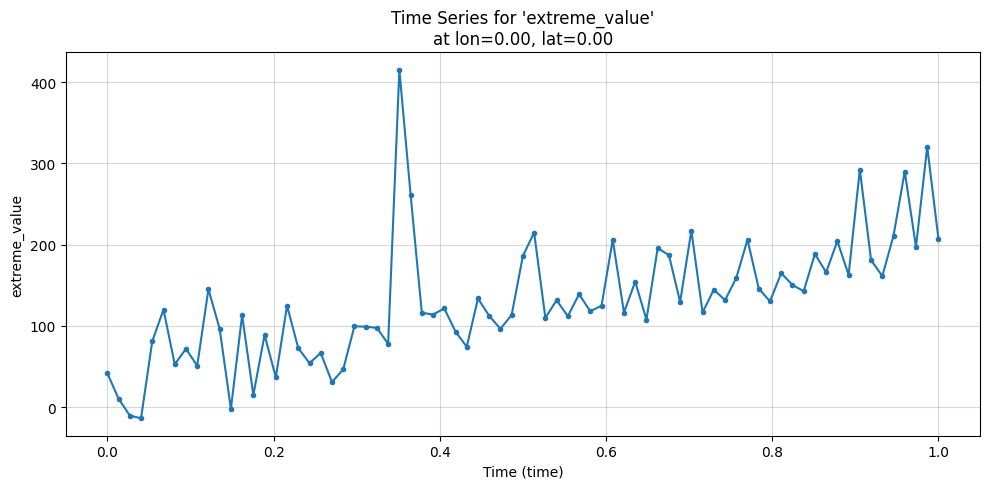

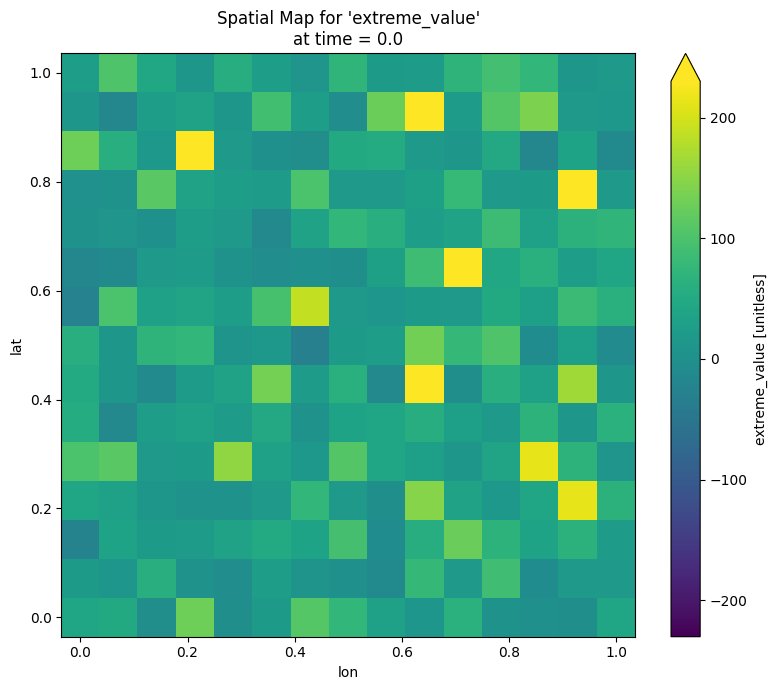

In [5]:
location_param = 0
scale_param = 11
shape_param = 0.1

# 2. Specify grid dimensions
x_dim_size = 10
y_dim_size = 10
t_dim_size = 75

def generate_linear_simple_trend(
    seed: int = 2,
    coeff_range:  Tuple[float, float] = (0, 10), 
    intercept_range: Tuple[float, float] = (10, 100), 
    t_coeff_range: Tuple[float, float] = (0, 10), 
    variable_choice: List[str] = ['x', 'y'] # Allow choosing variable
) -> TrendFunction:
    """
    Generates a simple linear trend lambda function (coeff * variable + intercept).

    Randomly selects a variable ('x' or 'y' by default), a coefficient from
    one of the provided ranges, and an intercept from the specified range.

    Args:
        seed (int): Seed for the random number generator.
        coeff_range (Tuple[float, float]): A tuple defining the min/max range
                                               for the coefficient.
        intercept_range (Tuple[float, float]): A tuple defining the min/max range
                                               for the intercept.
        variable_choice (List[str]): List of variables ('x', 'y', or 't') to choose from.
                                     Defaults to ['x', 'y'].

    Returns:
        TrendFunction: A lambda function matching the required signature
                       (lambda x_grid, y_grid, t_grid: ...) that calculates
                       the linear trend.

    Raises:
        ValueError: If variable_choice is empty or contains invalid variables.
    """
    rng = np.random.default_rng(seed)

    if not variable_choice:
        raise ValueError("variable_choice list cannot be empty.")

    # 1. Choose variable
    variable = rng.choice(variable_choice)
    if variable not in ['x', 'y', 't']:
         raise ValueError(f"Invalid variable '{variable}' chosen. Must be 'x', 'y', or 't'.")

    # 2. Choose coefficient range and sample coefficient
    chosen_range_index = rng.integers(len(coeff_range))
    coeff = rng.uniform(coeff_range[0], coeff_range[1])
    t_coeff = rng.uniform(t_coeff_range[0], t_coeff_range[1])
    # 3. Sample intercept (Corrected logic)
    intercept = rng.uniform(intercept_range[0], intercept_range[1])

    #Construct a clear string representation of the function
    func_str = f"f(x,y,t) = {intercept:.3f} + "
    if abs(coeff) > 1e-9: # Avoid printing "+ 0.000 * x"
        func_str += f" {coeff:.3f}*{variable} + "
    if abs(t_coeff) > 1e-9: # Avoid printing "+ 0.000 * t"
        func_str += f" {t_coeff:.3f}*t"

    print(f"Generated Trend Lambda: {func_str}")

    # 4. Return the lambda function
    if variable == 'x':
        return lambda x_grid, y_grid, t_grid: intercept + coeff * x_grid + t_coeff * t_grid
    elif variable == 'y':
        return lambda x_grid, y_grid, t_grid: intercept + coeff * y_grid + t_coeff * t_grid
    else:
        raise ValueError("Wrong Variable choice")


def generate_linear_non_isotropic_trend(
    seed: int = 42,
    coeff_range: List[Tuple[float, float]]=  [(-30.0, -15.0), (15.0, 30.0)],
    intercept_range: Tuple[float, float] = (-0.5, 0.5)
) -> str:
    """
    Generates a linear trend string depending on both 'x' AND 'y'.
    Formula: ax + by + c
    The intercept 'c' is chosen from one of the provided ranges.

    Args:
        seed: Seed for the random number generator.
        coeff_range: Tuple (min, max) for both x and y coefficients (a, b).
        intercept_ranges: A list of tuples [(min1, max1), (min2, max2), ...].
                          The intercept 'c' will be sampled uniformly from one
                          of these ranges, chosen randomly.

    Returns:
        A trend string like "1.234 * x - 0.567 * y + 25.111".
    """
    rng = np.random.default_rng(seed)
    chosen_range_index = rng.integers(len(coeff_range))
    coeff_x = rng.uniform(coeff_range[chosen_range_index][0], coeff_range[chosen_range_index][1])
    coeff_y = rng.uniform(coeff_range[chosen_range_index][0], coeff_range[chosen_range_index][1])

    chosen_range_index = rng.integers(len(intercept_range))
    min_val, max_val = intercept_range
    intercept = rng.uniform(min_val, max_val)

    return f"{coeff_x:.3f} * x {coeff_y:+.3f} * y {intercept:+.3f}"

def generate_polynomial_interaction_trend(
    seed: int = 42,
    max_degree: int = 3, # Max total degree (e.g., 2 allows x, y, x*y, x**2, y**2)
    term_prob: float = 0.7, # Probability of including any potential term
    coeff_range: Tuple[float, float] = [(-30.0, -15.0), (15.0, 30.0)]
) -> str:
    """
    Generates a polynomial trend string including interaction terms (like x*y).

    Creates a polynomial by randomly selecting terms up to a max_degree,
    where each term involves powers of x and y (e.g., c, ax, by, dx*y, ex**2, ...).

    Args:
        seed: Seed for the random number generator.
        max_degree: The maximum total degree for any term (deg_x + deg_y <= max_degree).
                    Must be >= 0.
        term_prob: Probability (0 to 1) that any potential valid term (up to max_degree)
                   is included in the final polynomial. Controls complexity/sparsity.
        coeff_range: Tuple (min, max) for the random coefficient of each term.

    Returns:
        A trend string representing the polynomial, e.g.,
        "0.500 + 1.200 * x - 0.800 * y + 1.100 * x * y - 0.300 * x**2".
        Returns "0.0" if no terms are selected.
    """
    
    if max_degree < 0:
        raise ValueError("max_degree must be non-negative")

    rng = np.random.default_rng(seed)
    chosen_range_index = rng.integers(len(coeff_range))
    terms_list = []

    for deg_x in range(max_degree + 1):
        for deg_y in range(max_degree - deg_x + 1):
            # Consider including this term (x**deg_x * y**deg_y)
            if rng.random() < term_prob:
                # Generate coefficient
                # Make constant term (0,0) less likely to be zero if it's selected
                if deg_x == 0 and deg_y == 0:
                     coeff = rng.uniform(coeff_range[chosen_range_index][0] / 2.0, coeff_range[chosen_range_index][1] / 2.0) # Smaller range for constant
                     if abs(coeff) < 1e-6 : coeff = 0.1 # Avoid tiny constant if possible
                else:
                     coeff = rng.uniform(coeff_range[chosen_range_index][0], coeff_range[chosen_range_index][1])


                # Skip term if coefficient is effectively zero (unless it's the constant)
                if abs(coeff) < 1e-6 and not (deg_x == 0 and deg_y == 0):
                    continue

                # --- Construct the term string ---
                term_parts = []
                # X part
                if deg_x == 1:
                    term_parts.append("x")
                elif deg_x > 1:
                    term_parts.append(f"x**{deg_x}")

                # Y part
                if deg_y == 1:
                    term_parts.append("y")
                elif deg_y > 1:
                    term_parts.append(f"y**{deg_y}")

                # Combine parts with coefficient
                if not term_parts: # Constant term (deg_x=0, deg_y=0)
                    term_string = f"{coeff:+.3f}"
                else:
                    # :+ ensures sign, .3f formats float, strip removes trailing space if needed
                    term_string = f"{coeff:+.3f} * {' * '.join(term_parts)}"

                terms_list.append(term_string)

    # --- Combine terms into final string ---
    if not terms_list:
        return "0.0" # Return "0.0" if no terms were selected

    # Join the strings. The :+.3f format ensures a sign for all terms.
    full_trend = " ".join(terms_list)
    # Remove leading '+' if the first term was positive.
    if full_trend.startswith('+'):
        full_trend = full_trend[1:].strip()
    elif full_trend.startswith('-'):
         full_trend = full_trend.strip() # Keep leading '-' but remove potential extra space

    # Handle case where the only term was a near-zero constant that formatted to "+0.000" or "-0.000"
    if full_trend == "0.000" or full_trend == "-0.000":
         return "0.0"
    # Handle case where only term selected was effectively zero coefficient non-constant term
    if not full_trend:
         return "0.0"


    return full_trend

def generate_multi_blob(
    num_blobs : int = 2,
    seed : int = 42,
    amplitude_range: Tuple[float, float] = (49, 50),
    center_range: Tuple[float, float] = (0, 1), # Avoid edges slightly
    decay_range: Tuple[float, float] = (30, 80.0),
    anisotropy_ratio_range: Tuple[float, float] = (1.5, 5.0),
    anisotropy_prob: float = 0.7
) -> str:
    """
    Generates a trend string representing the sum of multiple Gaussian blobs.

    Blob parameters (center, amplitude, decay, anisotropy) are randomized
    based on the provided seed.

    Args:
        num_blobs: The number of blobs to generate.
        seed: Seed for the random number generator for reproducibility.
        amplitude_range: Tuple (min, max) for the peak amplitude (A).
        center_range: Tuple (min, max) for the x and y center coordinates (cx, cy).
        decay_range: Tuple (min, max) for the base decay parameter (B or B_base).
                     Higher values mean narrower blobs.
        anisotropy_ratio_range: Tuple (min, max) for the ratio between the
                                stronger and weaker decay axes (Bx/By or By/Bx)
                                if the blob is anisotropic. Must be >= 1.
        anisotropy_prob: Probability (0 to 1) that any given blob will be
                         anisotropic.

    Returns:
        A string representing the mathematical function for the sum of blobs,
        suitable for use in `create_gev_nonstationary` trend functions.
    """
    if num_blobs <= 0:
        return "0.0" # Return a constant zero trend if no blobs requested

    rng = np.random.default_rng(seed)
    blob_strings = []

    for _ in range(num_blobs):
        # Random parameters for this blob
        cx = rng.uniform(center_range[0], center_range[1])
        cy = rng.uniform(center_range[0], center_range[1])
        A = rng.uniform(amplitude_range[0], amplitude_range[1])
        B_base = rng.uniform(decay_range[0], decay_range[1])

        is_anisotropic = rng.random() < anisotropy_prob

        if is_anisotropic and num_blobs > 0 : # Ensure ratio > 1 for anisotropy
             anisotropy_ratio = rng.uniform(anisotropy_ratio_range[0], anisotropy_ratio_range[1])
             stronger_axis = rng.choice(['x', 'y'])

             if stronger_axis == 'x':
                 Bx = B_base * anisotropy_ratio
                 By = B_base
             else: # Stronger along y
                 Bx = B_base
                 By = B_base * anisotropy_ratio

             # Format anisotropic blob string
             blob_str = (f"{A:+.3f} * np.exp(-({Bx:.3f} * (x - {cx:.3f})**2 + "
                         f"{By:.3f} * (y - {cy:.3f})**2))")
        else:
             # Format isotropic blob string (Bx = By = B_base)
              blob_str = (f"{A:+.3f} * np.exp(-{B_base:.3f} * ("
                          f"(x - {cx:.3f})**2 + (y - {cy:.3f})**2))")

        blob_strings.append(blob_str)

    # Join the strings. The :+.3f format ensures a sign for all terms.
    # We remove the leading '+' if the first term was positive.
    full_trend = " ".join(blob_strings)
    if full_trend.startswith('+'):
        full_trend = full_trend[1:].strip() # Remove leading '+' and space
    elif full_trend.startswith('-'):
        full_trend = full_trend.strip() # Keep leading '-' but remove space

    # Handle case where all amplitudes might be zero (unlikely but possible)
    if not full_trend:
        return "0.0"

    return full_trend

loc_trend_lambda = generate_simple_trend_st(seed=3,coeff_range=(10,20),t_coeff_range=(100,200))
ds_generated = create_gev_nonstationary(
    loc=0, scale=30, shape=0.2,
    trend_funcs={
        'loc': loc_trend_lambda[0],
        },
    num_x=15, num_y=15, num_t=75
    )
print(ds_generated)

plot_time(ds_generated)
plot_map(ds_generated)

Fitting

In [8]:
#print(gev_dataset_dimless.attrs["trend_slope_b1"])
endog, exog, mdt = xarray_to_endog_exog(ds = ds_generated["extreme_value"].to_dataset(),endog_var="extreme_value",include_time_coords=True, include_space_coords=True)
print(mdt)
exog.shape

{'t': 75, 'n_lat': 15, 'n_lon': 15, 's': 225, 'covariates': [{'name': 'lat', 'original_dims': ('lat',), 'is_coord': True}, {'name': 'lon', 'original_dims': ('lon',), 'is_coord': True}, {'name': 'time', 'original_dims': ('time',), 'is_coord': True}]}


(75, 3, 225)

In [7]:
print(exog.shape)
afit = GEVSample(endog=endog,exog={"location" : exog, "scale" : exog}).fit(fit_method='MLE')
print(afit)

(75, 3, 225)


INFO:root:Successfully computed covariance matrix using numdifftools.


16875

          EVT Results Summary       
Data dimensions : (75, 225)
AIC: 172143.75  
BIC: 172164.60  

+------------+--------------+--------------+--------------+---------------------------+----------+
| Parameter  | Estimate     | Z-score      | P>|Z-score|  | 95% CI                    | Signif   |
+------------+--------------+--------------+--------------+---------------------------+----------+
| μ_0        | 62.3089      | 81.37        | 0.0000       | (60.8081, 63.8096)        | ***      |
| μ_1        | 12.1320      | 14.94        | 0.0000       | (10.5408, 13.7233)        | ***      |
| μ_2        | 1.5178       | 1.87         | 0.0614       | (-0.0724, 3.1079)         |          |
| μ_3        | 179.5493     | 209.82       | 0.0000       | (177.8721, 181.2265)      | ***      |
| σ_0        | 30.8087      | 48.69        | 0.0000       | (29.5685, 32.0489)        | ***      |
| σ_1        | -0.9266      | -1.39        | 0.1659       | (-2.2376, 0.3843)         |          |
| 

In [6]:
def reconstruct_xarray_from_flat(
    prediction_params_flat: np.ndarray, 
    mdt: Dict[str, Any],
    original_ds: xr.Dataset
) -> xr.Dataset:
    """
    Reconstructs an xarray Dataset with GEV parameters (loc, scale, shape)
    from a flattened prediction array (parameters, time, space).

    Assumes the input array corresponds to loc, scale, shape in order along
    the first dimension.
    Reverses the flattening performed by xarray_to_endog_exog
    (which uses stack(space=('lat', 'lon'))).

    Args:
        prediction_params_flat: The 3D NumPy array prediction with shape
                                (3, T, S) for [loc, scale, shape], where
                                S = N_lat * N_lon.
        mdt: Metadata dictionary containing 't', 'n_lat', 'n_lon', 's'.
        original_ds: The original xarray Dataset from which the data was
                     flattened. Used to retrieve coordinates and ensure consistency.

    Returns:
        An xarray Dataset containing three data variables ('prediction_loc',
        'prediction_scale', 'prediction_shape'), each with dimensions
        ('lon', 'lat', 'time').

    Raises:
        ValueError: If shapes or metadata are inconsistent.
        TypeError: If prediction_params_flat is not a NumPy array.
    """
    # 1. Extract Dimensions from metadata
    try:
        T = mdt['t']
        N_lat = mdt['n_lat']
        N_lon = mdt['n_lon']
        S = mdt['s'] # Total spatial points
    except KeyError as e:
        raise ValueError(f"Metadata dictionary 'mdt' is missing required key: {e}")

    # --- Simplified Input Validation ---
    if not isinstance(prediction_params_flat, np.ndarray):
        raise TypeError("prediction_params_flat must be a NumPy array.")

    expected_shape_3d = (3, T, S)
    if prediction_params_flat.shape != expected_shape_3d:
            # Check if S in metadata was inconsistent but dims otherwise match
            if prediction_params_flat.shape[0] == 3 and \
               prediction_params_flat.shape[1] == T and \
               prediction_params_flat.shape[2] == N_lat * N_lon:
                 warnings.warn(f"Metadata inconsistency: mdt['s'] ({S}) != N_lat ({N_lat}) * N_lon ({N_lon}). "
                               f"Input array shape ({prediction_params_flat.shape}) matches (3, T, N_lat*N_lon). "
                               f"Proceeding by correcting S.", UserWarning)
                 S = N_lat * N_lon # Correct S based on dims
            else:
                 # Shape mismatch is real
                 raise ValueError(f"Input NumPy array prediction_params_flat has incorrect shape {prediction_params_flat.shape}. "
                                  f"Expected {expected_shape_3d} based on metadata (parameters, time, space).")
    # --- End Input Validation ---


    # 3. Get Coordinates from original dataset
    try:
        lon_coord_name = 'lon'
        lat_coord_name = 'lat'
        time_coord_name = 'time'

        lon_coords = original_ds[lon_coord_name]
        lat_coords = original_ds[lat_coord_name]
        time_coords = original_ds[time_coord_name]

        # Verify coordinate lengths match metadata dimensions
        if len(lon_coords) != N_lon:
            raise ValueError(f"Original dataset '{lon_coord_name}' coord length ({len(lon_coords)}) "
                             f"doesn't match metadata n_lon ({N_lon})")
        if len(lat_coords) != N_lat:
            raise ValueError(f"Original dataset '{lat_coord_name}' coord length ({len(lat_coords)}) "
                             f"doesn't match metadata n_lat ({N_lat})")
        if len(time_coords) != T:
             if len(time_coords) < T :
                  raise ValueError(f"Original dataset '{time_coord_name}' coord length ({len(time_coords)}) "
                             f"is less than metadata T ({T})")
             elif len(time_coords) > T:
                  warnings.warn(f"Original dataset '{time_coord_name}' coord length ({len(time_coords)}) "
                             f"is greater than metadata T ({T}). Using the first {T} time coordinates.", UserWarning)
                  time_coords = time_coords[:T]

    except KeyError as e:
        raise ValueError(f"Original dataset 'original_ds' is missing expected coordinate: {e}")

    # --- Reconstruct each parameter ---
    reconstructed_params = {}
    param_names = ['prediction_loc', 'prediction_scale', 'prediction_shape']

    for i, param_name in enumerate(param_names):
        # Extract the flattened data for this parameter: shape (T, S)
        param_flat = prediction_params_flat[i, :, :]

        # 4. Transpose and Reshape
        # Input shape (T, S) -> Transpose to (S, T)
        # Reshape S (where lon varied fastest) back to (N_lat, N_lon)
        # Resulting shape before final transpose: (N_lat, N_lon, T)
        try:
            reshaped_data_lat_lon_time = param_flat.T.reshape((N_lat, N_lon, T))
        except ValueError as e:
            raise ValueError(f"Reshaping failed for parameter '{param_name}' (to N_lat, N_lon, T). "
                             f"Check consistency. Original error: {e}")

        # 5. Create intermediate DataArray with (lat, lon, time) order
        param_da_intermediate = xr.DataArray(
            data=reshaped_data_lat_lon_time,
            coords=[lat_coords, lon_coords, time_coords],
            dims=[lat_coord_name, lon_coord_name, time_coord_name],
            name=param_name
        )

        # 6. Transpose to final desired order ('lon', 'lat', 'time')
        param_da_final = param_da_intermediate.transpose(lon_coord_name, lat_coord_name, time_coord_name)

        reconstructed_params[param_name] = param_da_final

    # 7. Create final Dataset
    reconstructed_ds = xr.Dataset(reconstructed_params)

    return reconstructed_ds

In [7]:
test = reconstruct_xarray_from_flat(np.stack(afit.gev_params,axis=0),mdt,ds_generated)
test

NameError: name 'afit' is not defined

In [8]:
plot_t_index = 0
print(f"\nPlotting spatial map for time index (time={plot_t_index})...")
plot_map(test, t_index=plot_t_index,var_name="prediction_loc")


Plotting spatial map for time index (time=0)...


NameError: name 'test' is not defined

Bias, Variance, MSE

In [9]:
def calculate_parameter_metrics(
    ground_truth_ds: xr.Dataset,
    fit_ds: xr.Dataset,
    true_param_mapping: Dict[str, str] = {
        # Updated mapping to likely variable names in your datasets
        'location': 'location', # Assuming 'location' is the variable name in fit_ds
        'scale': 'scale',       # Assuming 'scale' is the variable name in fit_ds
        'shape': 'shape'        # Assuming 'shape' is the variable name in fit_ds
    },
    fit_param_mapping: Dict[str, str] = {
         # Mapping for the ground truth dataset variable names
        'location': 'prediction_loc', # Assuming 'true_location' is the variable name in ground_truth_ds
        'scale': 'prediction_scale',
        'shape': 'prediction_shape'
    }
) -> Dict[str, Dict[str, float]]:
    """
    Calculates Bias, Variance of Error, MSE, RMSE, and their normalized
    versions by comparing fitted GEV parameters against true GEV parameters.

    Normalization:
        - nBias: Bias / mean(abs(True Values))
        - nRMSE: RMSE / mean(abs(True Values))
        - nVariance_of_error: Variance_of_error / variance(True Values)
          (Returns NaN if variance of True Values is zero).

    Args:
        fit_ds: Dataset containing the fitted parameters (e.g., 'location').
        ground_truth_ds: Dataset containing the true parameters (e.g., 'true_location').
        param_mapping: Dictionary mapping canonical parameter names (keys) to the
                       corresponding fitted parameter variable names (values)
                       in the fit_ds dataset.
        true_param_mapping: Dictionary mapping canonical parameter names (keys) to the
                       corresponding true parameter variable names (values)
                       in the ground_truth_ds dataset.

    Returns:
        A dictionary where keys are the canonical parameter names ('location', 'scale',
        'shape') and values are dictionaries containing the calculated scalar
        metrics ('bias', 'variance_of_error', 'mse', 'rmse', 'nBias',
        'nVariance_of_error', 'nRMSE') for that parameter.

    Raises:
        ValueError: If required variables are missing, datasets are incompatible,
                    or alignment/filtering results in no valid data points.
        KeyError: If parameter names in mapping are not found.
    """
    results = {}
    # Using dimensions from ground_truth_ds as reference, assuming they are standard
    # required_dims = set(ground_truth_ds.dims) # Not strictly needed with xr.align

    # Define a small epsilon for safe division checks
    EPSILON = 1e-9

    for param_name, true_var_name in true_param_mapping.items():
        fit_var_name = fit_param_mapping.get(param_name)

        # --- Check variables exist ---
        if fit_var_name not in fit_ds:
            raise KeyError(f"Fitted variable '{fit_var_name}' (for {param_name}) not found in fit_ds.")
        if not true_var_name or true_var_name not in ground_truth_ds:
            raise KeyError(f"True variable '{true_var_name}' (for {param_name}) not found in ground_truth_ds.")

        fit_da = fit_ds[fit_var_name]
        true_da = ground_truth_ds[true_var_name]

        # --- Align and Calculate Error ---
        try:
            # Align datasets - crucial if coordinates might differ slightly
            # Using inner join ensures only comparable points are used
            fit_aligned, true_aligned = xr.align(fit_da, true_da, join="inner")

            # Ensure float for calculations
            fit_aligned = fit_aligned.astype(float)
            true_aligned = true_aligned.astype(float)

            # Check for NaNs introduced by alignment or present in data
            valid_mask = np.isfinite(fit_aligned) & np.isfinite(true_aligned)
            if not valid_mask.any():
                 raise ValueError(f"Alignment/filtering resulted in zero valid overlapping points for parameter '{param_name}'. Check coordinates and NaNs.")

            # Apply mask ONLY for calculations, not changing array structure necessarily
            # Calculate error only on valid points
            error_da = xr.where(valid_mask, fit_aligned - true_aligned, np.nan)
            # Also create masked versions of true values for normalization calculation
            true_masked = true_aligned.where(valid_mask) # Keep NaNs where invalid

        except Exception as e:
            raise ValueError(f"Failed to align or subtract parameters '{fit_var_name}' and '{true_var_name}'. Check dimensions and coordinates. Original error: {e}")

        # --- Calculate Standard Metrics (operating on potentially masked data) ---
        # Use skipna=True for robustness against any remaining NaNs after masking
        bias = float(error_da.mean(skipna=True).item())

        # Check if bias calculation resulted in NaN (can happen if all error values were NaN)
        if np.isnan(bias):
             # If bias is NaN, all other metrics depending on error_da will also be NaN
             results[param_name] = {
                'bias': np.nan, 'variance_of_error': np.nan, 'mse': np.nan, 'rmse': np.nan,
                'nBias': np.nan, 'nVariance_of_error': np.nan, 'nRMSE': np.nan
            }
             warnings.warn(f"Bias calculation resulted in NaN for parameter '{param_name}'. Skipping metrics calculation.")
             continue # Skip to the next parameter

        mse = float((error_da**2).mean(skipna=True).item())
        rmse = np.sqrt(mse)
        # Calculate variance of the parameter error (population variance)
        variance_of_error = float(error_da.var(skipna=True).item())
        # --- Calculate Normalization Factors ---
        #mean_abs_true = float(abs(true_masked).mean(skipna=True).item())
        #var_true = float(true_masked.var(skipna=True).item())

        # --- Calculate Normalized Metrics ---
        #N_Bias = np.nan
        #N_RMSE = np.nan
        #N_Variance_of_error = np.nan # Renamed for clarity

        # Normalize Bias and RMSE using mean absolute true value
        #if not np.isnan(mean_abs_true) and abs(mean_abs_true) > EPSILON:
            #N_Bias = bias / mean_abs_true
            #N_RMSE = rmse / mean_abs_true
        #else:
             #warnings.warn(f"Mean absolute true value is NaN or near zero for '{param_name}'. Cannot calculate nBias and nRMSE.", UserWarning)


        ## Normalize Variance of Error using variance of true value
        #if not np.isnan(var_true) and abs(var_true) > EPSILON:
            #N_Variance_of_error = variance_of_error / var_true
        #else:
             # This often happens if the true parameter is constant
             #warnings.warn(f"Variance of true value is NaN or near zero for '{param_name}'. Cannot calculate nVariance_of_error.", UserWarning)

        # --- Store Results ---
        results[param_name] = {
            'bias': bias,
            'variance_of_error': variance_of_error,
            'mse': mse,
            'rmse': rmse,
            #'N_Bias': N_Bias,
            #'N_Variance_of_error': N_Variance_of_error, # Use descriptive name
            #'N_RMSE': N_RMSE,
        }

    return results

BIG SIM 

1] Trend in X

In [10]:
def sim_simple_trend_st(
    base_loc: float = 0.0,
    base_scale: float = 10.0,
    base_shape: float = 0.1,
    noise: float = 0.15,
    res: int = 3,
    num_simulations: int = 100,
    num_t: int = 75,
    trend_coeff_range: tuple = (-40, 40),
    trend_t_coeff_range: tuple = (0.1, 50),
    trend_intercept_range: tuple = (50, 100),
    fit_method: str = 'MLE',
    apply_start_noise: bool = False,
    show_progress: bool = True,
    random_seed_base: int = 0,
    metrics_to_track: List[str] = ['bias', 'variance_of_error', 'mse', 'rmse'],
    gev_params_order: List[str] = ['location', 'scale', 'shape'] # Define expected order
) -> Tuple[Dict[str, np.ndarray], List[str]]:
    """
    Runs Monte Carlo sims and returns RAW metrics for each run.

    Does NOT aggregate metrics over runs. Returns results suitable for
    external aggregation (e.g., within a parameter sweep).

    Args:
        # ... (Args mostly same as sim_simple_trend_st) ...
        metrics_to_track: List of metric names to collect.
        gev_params_order: Fixed order for the GEV parameters in output arrays.


    Returns:
        A tuple containing:
        - results_dict (Dict[str, np.ndarray]): Dictionary where keys are metric names.
              Values are numpy arrays of shape (num_successful_runs, num_gev_params),
              containing the raw metric value for each successful run and GEV parameter.
              The order of the last dimension corresponds to `gev_params_order`.
        - gev_params_order (List[str]): The list defining the order of the last
              dimension in the result arrays. (Returns the input list for confirmation).
        Returns ({}, gev_params_order) if no runs succeed.
    """
    # Use lists to collect results initially, easier appending
    raw_results_collector = {metric: [] for metric in metrics_to_track}
    num_successful_runs = 0
    num_gev_params = len(gev_params_order)
    rng = np.random.default_rng()

    iterable = range(num_simulations)
    if show_progress:
        iterable = tqdm(iterable, desc=f"Simulating (res={res})") # Add res to desc
        run_metrics_array = {metric: np.full(num_gev_params, np.nan) for metric in metrics_to_track} # Init with NaN for this run

    for i in iterable:
        current_seed = random_seed_base + i # Ensure different seeds across runs/sweeps
        run_metrics_array = {metric: np.full(num_gev_params, np.nan) for metric in metrics_to_track} # Init with NaN for this run

        try:
            # 1. Generate Trend Function (randomized by seed)
            loc_trend_lambda, loc_trend_params = generate_simple_trend_st(
                 seed=current_seed,
                 coeff_range=trend_coeff_range,
                 t_coeff_range=trend_t_coeff_range,
                 intercept_range=trend_intercept_range
            )

            # 3. Generate Ground Truth Dataset
            gev_ds = create_gev_nonstationary(
                loc=base_loc, scale=base_scale, shape=base_shape,
                trend_funcs={'loc': loc_trend_lambda},
                num_x=res, num_y=res, num_t=num_t,
            )

            # 4. Flatten Data for Fitting
            endog, exog, mdt = xarray_to_endog_exog(
                ds = gev_ds['extreme_value'].to_dataset(),
                endog_var="extreme_value",
                include_time_coords=True,
                include_space_coords=True
            )

            # 6. Fit Model
            fitter = GEVSample(endog=endog, exog={"location" : exog})

            # Prepare start_params - base assumes loc ~ intercept + x + y + t
            # The number of loc params = number of columns in exog_dict['location']
            afit = fitter.fit(fit_method=fit_method, start_params=[loc_trend_params[0],0,0,0,base_scale,0.1])
            # print(afit) # Optional: print fit summary

            # 7. Reconstruct Fitted Dataset
            # np.stack needs an iterable of things to stack. afit.gev_params is assumed
            # to be a list/tuple of the final parameters [loc_p1, loc_p2,..., scale, shape]
            fit_ds = reconstruct_xarray_from_flat(
                prediction_params_flat=np.stack(afit.gev_params, axis=0),
                mdt=mdt,
                original_ds=gev_ds
            )

            # 8. Calculate Metrics
            parameter_metrics = calculate_parameter_metrics(ground_truth_ds=gev_ds, fit_ds=fit_ds)
            # Store results in the pre-defined order
            for metric in metrics_to_track:
                for idx, param_name in enumerate(gev_params_order):
                    if param_name in parameter_metrics and metric in parameter_metrics[param_name]:
                        run_metrics_array[metric][idx] = parameter_metrics[param_name][metric]
                    # else: it remains NaN
                         
            # Append the collected array row for each metric to the lists
            for metric in metrics_to_track:
                raw_results_collector[metric].append(run_metrics_array[metric]) # Appends a 1D array
                num_successful_runs += 1
        except Exception as e:
            # This will catch errors in generation, fitting, reconstruction, metrics
            # Use warnings.warn for potentially less disruptive output than print
            #warnings.warn(f"Warning: Error in simulation run {i+1} (Seed={current_seed}, res={res}): {e}. Skipping run.")
            # import traceback # Optional for deeper debugging
            # traceback.print_exc()
            continue # Continue to the next simulation run

    # --- Convert collected lists to final numpy arrays ---
    final_results_dict = {}
    if num_successful_runs > 0:
        for metric in metrics_to_track:
            # Stack the list of 1D arrays into a 2D array (n_runs, n_params)
            final_results_dict[metric] = np.stack(raw_results_collector[metric], axis=0)

    return final_results_dict, gev_params_order

def aggregate_simulation_results(
    raw_results_dict: Dict[str, np.ndarray],
    gev_params_order: List[str],
    aggregation_func: Callable = np.nanmean
) -> Dict[str, np.ndarray]:
    """
    Aggregates raw simulation results over the runs dimension.

    Args:
        raw_results_dict: Dictionary where keys are metric names and values are
                          numpy arrays of shape (num_successful_runs, num_gev_params)
                          containing raw metric values.
        gev_params_order: The list defining the order of the last dimension
                          in the arrays within raw_results_dict.
        aggregation_func: The numpy function used to aggregate across the
                          simulation runs (axis=0). Default: np.nanmean.

    Returns:
        Dict[str, np.ndarray]: Dictionary where keys are metric names and
                               values are numpy arrays of shape (num_gev_params,)
                               containing the aggregated metric value for each
                               GEV parameter. Returns an empty dict if input is empty.
    """
    aggregated_metrics = {}
    if not raw_results_dict:
        return aggregated_metrics # Return empty if no raw results

    num_gev_params = len(gev_params_order)

    for metric, raw_array in raw_results_dict.items():
        if raw_array.ndim == 2 and raw_array.shape[1] == num_gev_params and raw_array.size > 0:
            # Aggregate over runs (axis=0), result is shape (n_params,)
            try:
                aggregated_metrics[metric] = aggregation_func(raw_array, axis=0)
            except Exception as e:
                 warnings.warn(f"Failed to aggregate metric '{metric}' with function '{aggregation_func.__name__}': {e}. Skipping metric.")
                 aggregated_metrics[metric] = np.full(num_gev_params, np.nan) # Fill with NaN on failure
        elif raw_array.ndim == 1 and raw_array.shape[0] == num_gev_params and raw_array.size >0 :
             # Handle case where input might already be aggregated (e.g. only 1 simulation run)
             # Or if input structure was different than expected.
             # For now, assume if 1D, it's already aggregated or represents a single run.
             # If it's a single run, aggregation might change its meaning, let's just pass it through
             # or raise a warning. Passing through might be unexpected. Let's warn and NaN fill.
              warnings.warn(f"Input array for metric '{metric}' is 1D. Aggregation function expects axis 0. Returning NaNs.")
              aggregated_metrics[metric] = np.full(num_gev_params, np.nan)
        else:
            # Handle empty arrays or shape mismatches
            warnings.warn(f"Skipping metric '{metric}' due to unexpected shape {raw_array.shape} or empty array.")
            aggregated_metrics[metric] = np.full(num_gev_params, np.nan) # Fill with NaN

    return aggregated_metrics


In [13]:
# Placeholder/Assumed functions (generate_simple_trend_st, etc.) remain the same
# Import or define sim_simple_trend_st_raw as defined in the previous step

def run_simulation_sweep_agg( # Name unchanged, but logic updated
    sim_func_raw: Callable[..., Tuple[Dict[str, np.ndarray], List[str]]],
    param_sweep_config: Dict[str, List[Any]],
    fixed_params: Dict[str, Any],
    aggregation_func: Callable = np.nanmean,
    # metrics_order: Optional[List[str]] = None # If needed for final dataset structure
) -> xr.Dataset:
    """
    Runs a raw simulation function over a grid of parameters, aggregates the
    results using a separate aggregation function, and collects them into an
    xarray Dataset.

    Args:
        sim_func_raw: Raw simulation function (e.g., sim_simple_trend_st_raw).
        param_sweep_config: Dictionary defining parameters to sweep.
        fixed_params: Dictionary of fixed parameters for sim_func_raw.
        aggregation_func: Numpy function for aggregating across runs (axis=0).
        # metrics_order: Optional list to define metric order in output dataset.

    Returns:
        An xarray Dataset containing the aggregated simulation results.
    """
    sweep_param_names = list(param_sweep_config.keys())
    sweep_param_values_lists = list(param_sweep_config.values())
    param_combinations = list(itertools.product(*sweep_param_values_lists))

    # Store aggregated results per combo: {combo_tuple: {metric: np.array(n_params)}}
    aggregated_results_store = {}
    gev_params_order = None
    all_metrics_detected = set() # Keep track of all metrics seen

    print(f"Starting parameter sweep (ext agg): {sweep_param_names}")
    print(f"Total combinations: {len(param_combinations)}")

    for combo in tqdm(param_combinations, desc="Parameter Sweep (ext agg)"):
        current_sweep_params = dict(zip(sweep_param_names, combo))
        current_run_params = {**fixed_params, **current_sweep_params}
        current_run_params['show_progress'] = True

        try:
            # 1. Run the raw simulation function
            raw_results_dict, current_gev_params = sim_func_raw(**current_run_params)

            if not raw_results_dict:
                 warnings.warn(f"Raw simulation returned no results for combo: {current_sweep_params}. Skipping.")
                 aggregated_results_store[combo] = None
                 continue

            # Set/verify gev_params_order and update detected metrics
            if gev_params_order is None:
                gev_params_order = current_gev_params
            elif gev_params_order != current_gev_params:
                 warnings.warn("Inconsistent GEV parameter order returned!")
                 # Handle error or proceed with the first order? Proceeding for now.

            # 2. Aggregate results using the separate function
            combo_aggregated_metrics = aggregate_simulation_results(
                raw_results_dict=raw_results_dict,
                gev_params_order=gev_params_order, # Use the determined order
                aggregation_func=aggregation_func
            )

            if not combo_aggregated_metrics:
                 warnings.warn(f"Aggregation resulted in empty dictionary for combo: {current_sweep_params}. Skipping.")
                 aggregated_results_store[combo] = None
                 continue

            # Store the aggregated results (dictionary of 1D arrays)
            aggregated_results_store[combo] = combo_aggregated_metrics
            all_metrics_detected.update(combo_aggregated_metrics.keys()) # Track metrics found

        except Exception as e:
            warnings.warn(f"Error during simulation/aggregation for combo {current_sweep_params}: {e}. Skipping combo.")
            aggregated_results_store[combo] = None

    # --- Process results into xarray Dataset ---
    if not aggregated_results_store or all(v is None for v in aggregated_results_store.values()):
        print("No simulation combinations completed successfully or returned data.")
        return xr.Dataset()

    if gev_params_order is None:
         # Should have been set if any run succeeded
         print("Error: Could not determine GEV parameter order.")
         return xr.Dataset()

    # Use all metrics detected across all runs
    all_metrics = sorted(list(all_metrics_detected)) # Sort for consistent order

    # Define coordinates
    coords = {name: values for name, values in param_sweep_config.items()}
    coords['gev_param'] = gev_params_order

    # Create empty numpy arrays for the final xarray dataset
    data_vars_np = {}
    output_shape = tuple(len(v) for v in sweep_param_values_lists) + (len(gev_params_order),)
    for metric in all_metrics:
        data_vars_np[metric] = np.full(output_shape, np.nan)

    # Fill the numpy arrays (logic remains same as previous version)
    sweep_indices_generator = itertools.product(*(range(len(v)) for v in sweep_param_values_lists))
    param_combo_list = list(itertools.product(*sweep_param_values_lists))

    for i, combo_indices in enumerate(sweep_indices_generator):
        combo_tuple = param_combo_list[i]
        aggregated_metrics = aggregated_results_store.get(combo_tuple)

        if aggregated_metrics:
            for metric in all_metrics:
                 if metric in aggregated_metrics:
                     metric_array_1d = aggregated_metrics[metric]
                     if metric_array_1d.shape == (len(gev_params_order),):
                         np_index = combo_indices
                         data_vars_np[metric][np_index] = metric_array_1d
                     # else: Handle shape mismatch (warning already in aggregate func?)
                 # else: Metric not present for this combo (leave NaN)
        # else: Combo failed (leave NaNs)

    # Create xarray DataArrays
    data_vars_xr = {}
    output_dims = sweep_param_names + ['gev_param']
    for metric in all_metrics:
        data_vars_xr[metric] = xr.DataArray(
            data_vars_np[metric],
            coords=coords,
            dims=output_dims,
            name=metric
        )

    # Create final Dataset
    results_ds = xr.Dataset(data_vars_xr)
    results_ds.attrs['description'] = f"Aggregated simulation sweep results from sim_func '{sim_func_raw.__name__}'"
    results_ds.attrs['aggregation_function'] = aggregation_func.__name__
    results_ds.attrs['sweep_parameters'] = sweep_param_names
    results_ds.attrs['fixed_parameters'] = str(fixed_params)

    print("\nParameter sweep finished (external aggregation).")
    return results_ds

In [ ]:
common_params = {
    'base_loc': 0,
    'base_scale': 10,
    'base_shape': 0.1,
    'noise': 0.15,
    'num_simulations': 100, # Reduce for faster example run
    'num_t': 75,
    'trend_coeff_range': (-30, 30),
    'trend_t_coeff_range': (0.1, 30),
    'trend_intercept_range': (50, 80),
    'fit_method': 'MLE',
    'apply_start_noise': False,
    'random_seed_base': 2025,
    'metrics_to_track': ['bias', 'rmse'], # Specify metrics needed
    'gev_params_order': ['location', 'scale', 'shape'] # Specify order
}

# --- Define parameters to sweep ---
sweep_config = {
    'res': [2, 3, 5] # Vary 'res' over these values
}

# --- Run the sweep using the raw simulation and aggregate sweep function ---
sweep_results_ds_agg = run_simulation_sweep_agg(
    sim_func_raw=sim_simple_trend_st, # Use the raw results function
    param_sweep_config=sweep_config,
    fixed_params=common_params,
    aggregation_func=np.nanmean # Specify aggregation method
)

# --- Display results ---
print("\n--- Simulation Sweep Results (NumPy Aggregation -> xarray Dataset) ---")
print(sweep_results_ds_agg)

Starting parameter sweep (ext agg): ['res']
Total combinations: 3


Parameter Sweep (ext agg): 100%|██████████| 3/3 [00:32<00:00, 10.94s/it]


Parameter sweep finished (external aggregation).

--- Simulation Sweep Results (NumPy Aggregation -> xarray Dataset) ---
<xarray.Dataset> Size: 252B
Dimensions:    (res: 3, gev_param: 3)
Coordinates:
  * res        (res) int32 12B 2 3 5
  * gev_param  (gev_param) <U8 96B 'location' 'scale' 'shape'
Data variables:
    bias       (res, gev_param) float64 72B 0.401 -0.9296 ... 1.125 -0.01816
    rmse       (res, gev_param) float64 72B 5.89 0.9296 0.2111 ... 1.125 0.01816
Attributes:
    description:           Aggregated simulation sweep results from sim_func ...
    aggregation_function:  nanmean
    sweep_parameters:      ['res']
    fixed_parameters:      {'base_loc': 0, 'base_scale': 10, 'base_shape': 0....



--- RMSE for Scale Parameter vs. Resolution ---
<xarray.DataArray 'rmse' (res: 3)> Size: 24B
array([0.92955879, 0.30706175, 1.12522977])
Coordinates:
  * res        (res) int32 12B 2 3 5
    gev_param  <U8 32B 'scale'


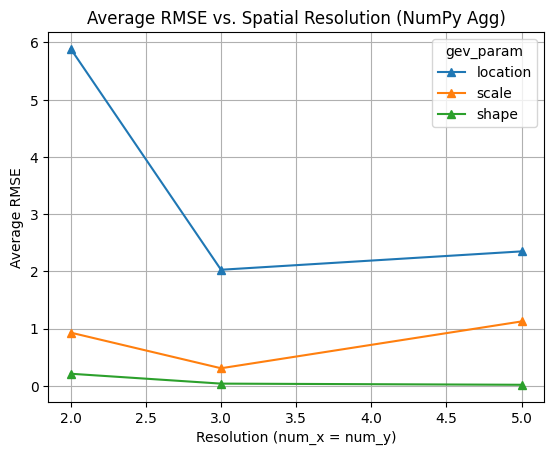

In [16]:
# --- Example: Accessing specific data ---
if 'rmse' in sweep_results_ds_agg and 'res' in sweep_results_ds_agg.coords:
    try:
        print("\n--- RMSE for Scale Parameter vs. Resolution ---")
        print(sweep_results_ds_agg['rmse'].sel(gev_param='scale'))

        # --- Example: Plotting (requires matplotlib) ---
        import matplotlib.pyplot as plt

        # Plot nRMSE vs resolution for each GEV parameter
        nrmse_data = sweep_results_ds_agg['rmse']
        nrmse_data.plot.line(x='res', hue='gev_param', marker='^') # Use different marker
        plt.title('Average RMSE vs. Spatial Resolution (NumPy Agg)')
        plt.xlabel('Resolution (num_x = num_y)')
        plt.ylabel('Average RMSE')
        plt.grid(True)
        plt.show()

    except ImportError:
        print("\nMatplotlib not installed. Skipping plot example.")
    except Exception as plot_e:
        print(f"\nError during plotting: {plot_e}")

In [292]:
sweep_results_ds_agg

<xarray.Dataset> Size: 252B
Dimensions:    (res: 3, gev_param: 3)
Coordinates:
  * res        (res) int32 12B 3 5 10
  * gev_param  (gev_param) <U8 96B 'location' 'scale' 'shape'
Data variables:
    bias       (res, gev_param) float64 72B 1.163 1.281 ... 0.04208 -0.008513
    rmse       (res, gev_param) float64 72B 1.401 1.281 ... 0.04208 0.008513
Attributes:
    description:           Aggregated simulation sweep results from sim_func ...
    aggregation_function:  nanmean
    sweep_parameters:      ['res']
    fixed_parameters:      {'base_loc': 0, 'base_scale': 10, 'base_shape': 0....

In [212]:
summary_df_formatted

parameter,location,scale,shape
bias,0.716717,0.328236,-0.013022
variance_of_error,0.077833,0.000000,0.000000
mse,0.591517,0.107739,0.000170
rmse,0.769101,0.328236,0.013022
